In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
train_features_file = Path("data/train_features.parquet")
train_df = pl.read_parquet(train_features_file, use_pyarrow=True, memory_map=True)
test_features_file = Path("data/test_features.parquet")
test_df = pl.read_parquet(test_features_file, use_pyarrow=True, memory_map=True)

In [3]:
def sample_from_group(sub_df):
    samples_per_class = 200
    random_seed = 42
    return sub_df.sample(
        min(samples_per_class, len(sub_df)), with_replacement=False, seed=random_seed
    )


train_sampled_df = train_df.group_by("ClassId").map_groups(sample_from_group)
del train_df

In [4]:
X_train = np.asarray(train_sampled_df["HOG_Features"].to_list())
y_train = train_sampled_df["ClassId"].to_numpy()

X_test = np.asarray(train_sampled_df["HOG_Features"].to_list())
y_test = train_sampled_df["ClassId"].to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42
# )

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
svm_classifier = SVC(
    kernel="rbf", degree=4, C=1.0, random_state=42
)  # linear, poly, rbf
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9994186046511628


In [8]:
cm = confusion_matrix(y_test, y_pred)

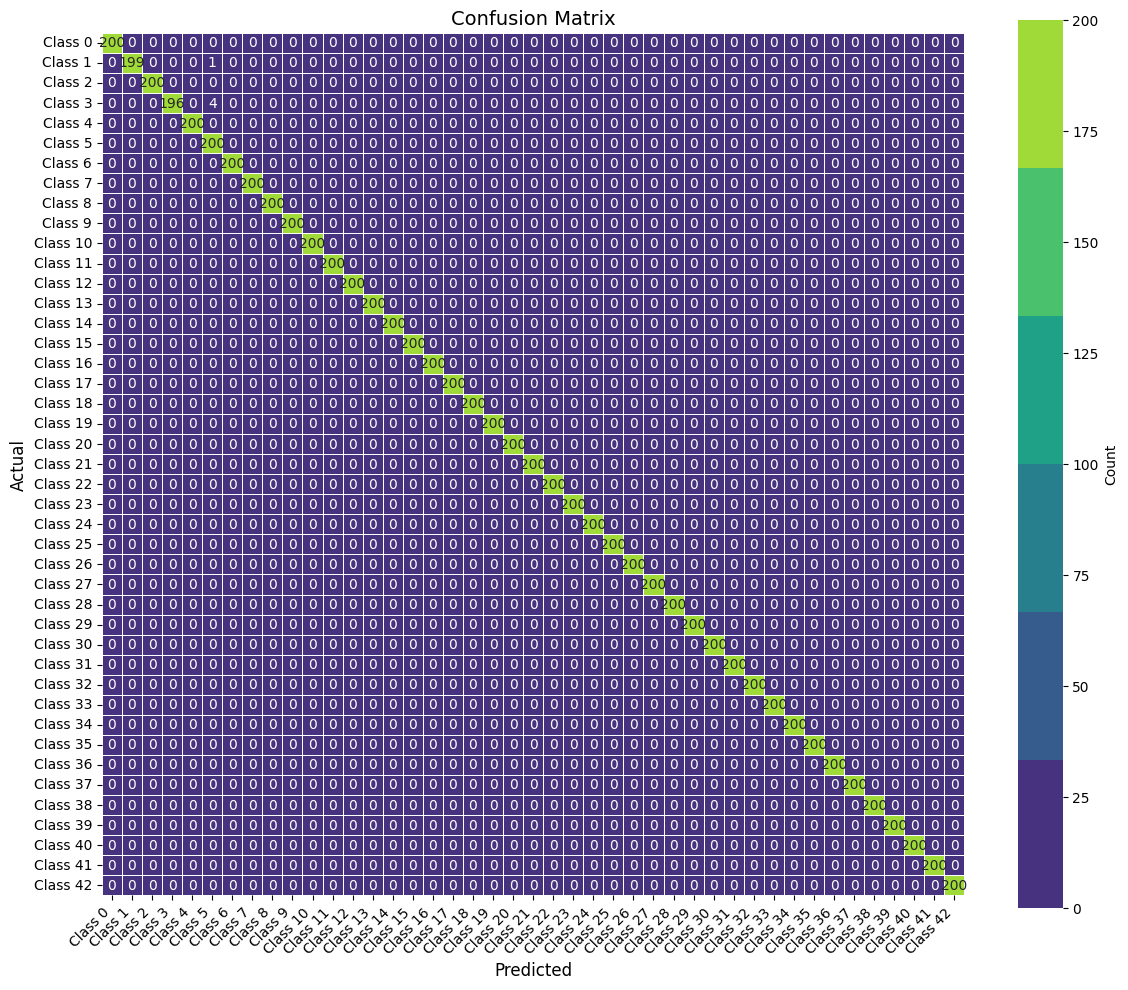

In [9]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]

# Use seaborn's heatmap with a diverging color palette
cmap = ListedColormap(sns.color_palette("viridis"))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Create a color bar manually using ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

# Create an Axes object for the color bar
# cax = plt.axes([0.95, 0.1, 0.02, 0.8])

# Add a color bar legend
# cbar = plt.colorbar(sm, cax=cax, orientation='vertical', label='Count')
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label("Count", rotation=270, labelpad=15, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()